## **uv-theory for mixtures**
$a = a_d^\text{hs}+\Delta a_0 + \Delta a_1^u + \sum_i \sum_j x_i x_j \psi_{ij}(\Delta B_{2,ij} - \Delta B_{21, ij}^u)$
with

 1.  $\psi_{ij} = 1 - \phi_{ij}^u$ and $\phi_{ij}^u=0.5(\phi_{ii} + \phi_{jj})$
 2. $\psi_{ij} = 1 - \phi_{ij}^u$ and $\phi_{ij}^u=\sqrt{\phi_{ii}  \phi_{jj}}$
 3. $\psi_{ij} = \sqrt{(1 - \phi_{ii})(1- \phi_{jj}) }$

 4. Something else?
 
For geometric averages: Values in the square root must not become negtive!!!

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from feos.si import *
from feos.eos import *
from feos.uvtheory import *

In [5]:
# Test LJ CP
m = 1
rep = 12
att = 6
eps_k = 1
sigma = 1
params = UVParameters.new_simple(m, rep, att, sigma, eps_k)
uv_wca_pure = EquationOfState.uvtheory(params, perturbation=Perturbation.BarkerHenderson)

In [6]:
State.critical_point(uv_wca_pure)

|temperature|density|
|-|-|
|1.57275 K|524.08643 kmol/m³|

In [9]:
m = [1, 1]
rep = [12.0, 12.0]
att = [6.0, 6.0]
sigma = [1.0, 1.5]
eps_k = [1.0, 1.0]

In [11]:
density = 0.1 / sigma[0]**3 / ANGSTROM**3 / NAV
temperature = 1.0 * eps_k[0] * KELVIN
molefracs = np.array([0.5, 0.5])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)

eos_uv_1 = EquationOfState.uvtheory(params, perturbation=Perturbation.BarkerHenderson, virial_order=VirialOrder.Second, combination_rule=CombinationRule.ArithmeticPhi)

In [12]:
State.critical_point(eos_uv_1, molefracs * MOL, initial_temperature=1.0*KELVIN)

|temperature|density|molefracs
|-|-|-|
|1.65376 K|237.90288 kmol/m³|[0.50000, 0.50000]|

In [13]:
#State.critical_point(eos_uvb3, molefracs * MOL, initial_temperature=1.0*KELVIN, verbosity=Verbosity.Iter)

In [14]:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 1.5])
eps_k = np.array([1.0, 1.0])

In [16]:
params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)

eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

In [17]:
dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)

In [19]:
data_vrabec = {
    'T': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    'x1': [0.00000, 0.10156, 0.30078, 0.50000, 0.69922, 0.90000, 1.00000],
    'y1': [0.00000, 0.1934, 0.4889, 0.705, 0.8707, 0.9713, 1.00000],
    'p': [0.00742, 0.00815, 0.01056, 0.01347, 0.01675, 0.02196, 0.02505],
    'uncert_p': [7, 18, 22, 23, 26, 41, 22],
    'rho_l': [0.70081, 0.69236, 0.68394, 0.67859, 0.67993, 0.68930, 0.70081],
    'uncert_rhol': [38, 96, 90, 83, 87, 12, 38],
    'rho_v': [0.02964, 0.02698, 0.02556, 0.02482, 0.02404, 0.02698, 0.02964],
    'uncert_rhov': [32, 74, 67, 56, 48, 61, 32]
}

df_vrabec = pd.DataFrame(data_vrabec)

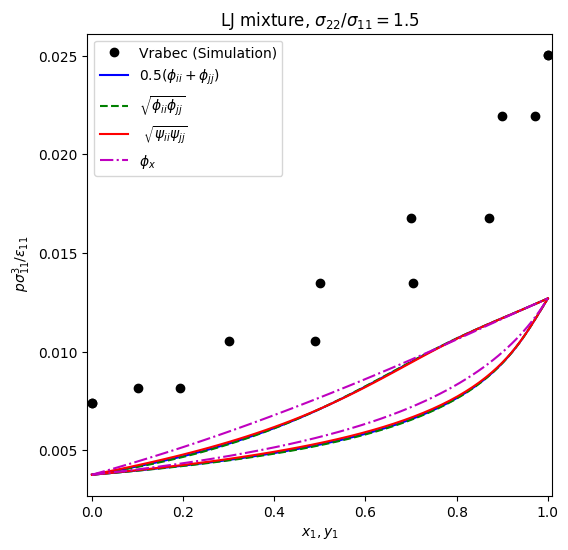

In [20]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(-0.01,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 1.5$')



ax.plot(data_vrabec['x1'] , data_vrabec['p'], 'ko', label='Vrabec (Simulation)')
ax.plot(data_vrabec['y1'] , data_vrabec['p'], 'ko')

#plt.plot(df['x1'], df['p'], 'b-', label='One Fluid u-fraction  $\\phi_x$')
#plt.plot(df['y1'], df['p'], 'b')



ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '-', color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g', label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g')

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r-', label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r-')

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'm-.')

ax.legend()

In [22]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 1.0])
eps_k = np.array([1.0, 0.50])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)
eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, combination_rule=CombinationRule.OneFluidPsi)

In [23]:
dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)

In [24]:
one_fluid_res = {
    'x1': [1.        , 0.9894168 , 0.97883359, 0.96825039, 0.95766718,
       0.94708398, 0.93650078, 0.92591757, 0.91533437, 0.90475116,
       0.89416796, 0.88358475, 0.87300155, 0.86241835, 0.85183514,
       0.84125194, 0.83066873, 0.82008553, 0.80950233, 0.79891912,
       0.78833592, 0.77775271, 0.76716951, 0.7565863 , 0.7460031 ,
       0.7354199 , 0.72483669, 0.71425349, 0.70367028, 0.69308708,
       0.68250388, 0.67192067, 0.66133747, 0.65075426, 0.64017106,
       0.62958785, 0.61900465, 0.60842145, 0.59783824, 0.58725504,
       0.57667183, 0.56608863, 0.55550543, 0.54492222, 0.53433902,
       0.52375581, 0.51317261, 0.5025894 , 0.4920062 , 0.481423  ,
       0.47083979],
    'y1': [1.        , 0.87130797, 0.77673823, 0.70449341, 0.64766116,
       0.60192347, 0.56444456, 0.53328564, 0.50707681, 0.48482312,
       0.46578503, 0.44940181, 0.4352411 , 0.42296461, 0.41230429,
       0.40304545, 0.39501457, 0.38807032, 0.3820968 , 0.37699852,
       0.37269642, 0.36912486, 0.36622911, 0.36396345, 0.36228945,
       0.36117462, 0.36059116, 0.36051489, 0.36092427, 0.36179957,
       0.36312211, 0.36487373, 0.36703649, 0.36959261, 0.37252472,
       0.37581647, 0.37945335, 0.38342369, 0.38771972, 0.39233864,
       0.39728352, 0.40256404, 0.40819712, 0.41420749, 0.42062817,
       0.42750104, 0.43487757, 0.44281966, 0.45140077, 0.46070722,
       0.47083979],
    'pv': [0.02463724, 0.02888583, 0.03307424, 0.03720321, 0.04127351,
       0.04528589, 0.04924112, 0.05313993, 0.05698308, 0.06077131,
       0.06450534, 0.0681859 , 0.07181371, 0.07538945, 0.07891382,
       0.08238746, 0.08581103, 0.08918513, 0.09251033, 0.09578715,
       0.09901608, 0.10219751, 0.10533178, 0.10841912, 0.11145963,
       0.11445327, 0.11739984, 0.12029891, 0.12314977, 0.12595145,
       0.12870256, 0.13140133, 0.13404545, 0.1366321 , 0.13915777,
       0.14161828, 0.14400868, 0.14632317, 0.14855503, 0.15069653,
       0.15273886, 0.15467195, 0.15648435, 0.15816297, 0.15969288,
       0.16105689, 0.16223523, 0.16320494, 0.16393937, 0.16440734,
       0.16457244],
    'pl':[0.02463724, 0.02888583, 0.03307424, 0.03720321, 0.04127351,
       0.04528589, 0.04924112, 0.05313993, 0.05698308, 0.06077131,
       0.06450534, 0.0681859 , 0.07181371, 0.07538945, 0.07891382,
       0.08238746, 0.08581103, 0.08918513, 0.09251033, 0.09578715,
       0.09901608, 0.10219751, 0.10533178, 0.10841912, 0.11145963,
       0.11445327, 0.11739984, 0.12029891, 0.12314977, 0.12595145,
       0.12870256, 0.13140133, 0.13404545, 0.1366321 , 0.13915777,
       0.14161828, 0.14400868, 0.14632317, 0.14855503, 0.15069653,
       0.15273886, 0.15467195, 0.15648435, 0.15816297, 0.15969288,
       0.16105689, 0.16223523, 0.16320494, 0.16393937, 0.16440734,
       0.16457244]
    
    
    
}
one_fluid_df = pd.DataFrame(one_fluid_res)

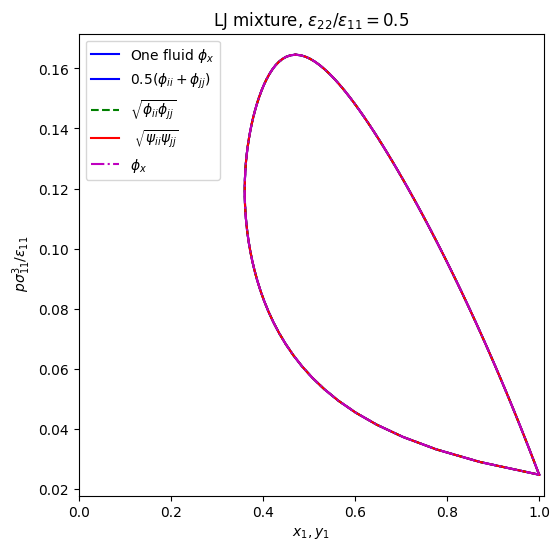

In [25]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\varepsilon_{22} / \\varepsilon_{11} = 0.5$')



ax.plot(one_fluid_df['x1'] , one_fluid_df['pl'], 'b', label='One fluid $\\phi_x$')
ax.plot(one_fluid_df['y1'] , one_fluid_df['pv'], 'b')

#plt.plot(df['x1'], df['p'], 'b-', label='One Fluid u-fraction  $\\phi_x$')
#plt.plot(df['y1'], df['p'], 'b')



ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '-', color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g', label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g')

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r-', label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r-')

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'm-.')

ax.legend()


In [25]:
data_sig2_sig1_05 = {
    'T': [1.00,1.00,1.00,1.00,1.00,1.00,1.00],
    
    'p':[0.03085,0.04,	0.05	,0.075	,0.1,0.125	,0.15,	    ],
    'x1':[0.87515336,0.7488606,0.63339615,0.4365508,0.27925158,0.19074777,0.11091277,],
    'x2':[0.68014145,0.48342085,0.34628806,0.14998586,0.051191095,0.03581933,0.013405361,     
    ]
} # referemce data Harismiadis

df1 = pd.DataFrame(data_sig2_sig1_05)

In [26]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 0.5])
eps_k = np.array([1.0, 1.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)

eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

In [27]:
dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN, npoints=81)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN, npoints=41,  max_iter_inner=800,    max_iter_outer=800)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN, npoints=81,  max_iter_inner=600,
    max_iter_outer=600 )

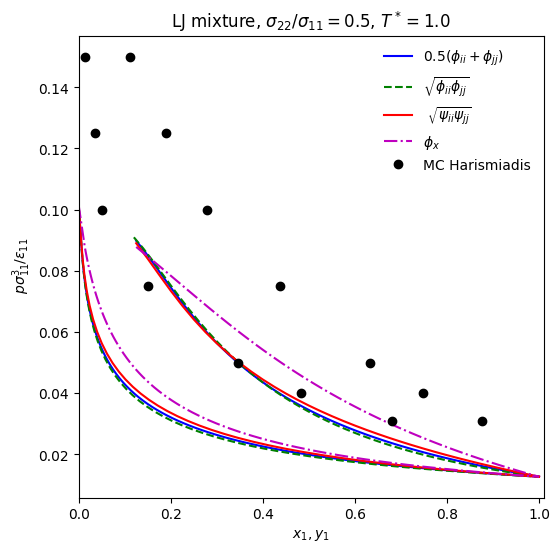

In [28]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 0.5$, $T^*=1.0$')

ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '-', color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g', label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g')

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r-', label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r-')

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'm-.')



plt.plot(df1['x1'], df1['p'], 'ko', label='MC Harismiadis')
plt.plot(df1['x2'], df1['p'], 'ko')
plt.legend(frameon=False)

In [30]:
data = [
    [1.00, 0.05, 0.92008126, 0.5568408],
    [1.00, 0.1, 0.78524196, 0.28388235],
    [1.00, 0.2, 0.61616147, 0.15504083],
    [1.00, 0.35, 0.42643267, 0.082767725],
    [1.00, 0.5, 0.32370824, 0.06541605],
    [1.00, 0.7, 0.22806972, 0.08016359],
    [1.00, 0.9, 0.12971175, 0.09164759]
]

df2 = pd.DataFrame(data, columns=['T*', 'p*', 'x1', 'x2'])
#print(df2)

In [32]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 0.5])
eps_k = np.array([2.0, 1.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)

eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

In [33]:
dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN, npoints=81)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN, npoints=81)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN, npoints=211)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN, npoints=81,  max_iter_inner=600,
    max_iter_outer=600 )

RuntimeError: `Critical point` did not converge within the maximum number of iterations.

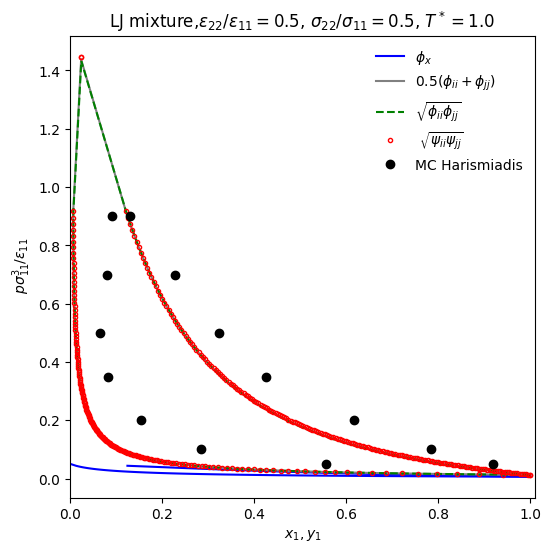

In [34]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture,$\\varepsilon_{22} / \\varepsilon_{11} = 0.5$, $\\sigma_{22} / \sigma_{11} = 0.5$, $T^*=1.0$')

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '-', color='blue', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '-',  color='blue')

ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), color='gray', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '-', color='gray')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g', label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), '--g')

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r.', fillstyle='none', label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM**3), 'r.', fillstyle='none')

plt.plot(df2['x1'], df2['p*'], 'ko', label='MC Harismiadis')
plt.plot(df2['x2'], df2['p*'], 'ko')
plt.legend(frameon=False)